# PLS Regression

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

## Get Data

In [2]:
from common.data import get_data

X, Y, demographics, population = get_data()
ages = demographics['Age']

print(f'X: {X.shape} | Y: {len(Y.keys())} | Age: {ages.shape} | Population: {population}')

X: (380, 34716) | Y: 16 | Age: (380,) | Population: adhd


In [4]:
from common.scoring import unimetric_scorer, multimetric_scorer, N_PERM, SCORING, RKF_10_10
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_validate, permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## Run for one target, one age bin

In [5]:
selected_target = "WISC_FSIQ"
y = Y[selected_target]

print(f'y: {y.shape}')

y: (380,)


In [6]:
from common.binning import bin_by_age

bins = bin_by_age(X, y, ages, y, True)
bin_1, bin_2, bin_3 = bins[0], bins[1], bins[2]
print(f'Bin 1: {bin_1[0].shape} | Bin 2: {bin_2[0].shape} | Bin 3: {bin_3[0].shape}')

Bin 0 Range: 6.03 -> 8.98
Bin 1 Range: 9.04 -> 11.96
Bin 2 Range: 12.03 -> 15.98
---
Bin 0 Range: 73.00 -> 138.00
Bin 1 Range: 70.00 -> 141.00
Bin 2 Range: 71.00 -> 147.00
---
Bin 1: (114, 34716) | Bin 2: (152, 34716) | Bin 3: (114, 34716)


### Set up the model pipeline, metrics, and cross-validation approach

In [7]:
estimators = [StandardScaler(), PLSRegression(n_components=4)]
pipe = make_pipeline(*estimators)

### Run cross-validation

In [8]:
%%time
# X_cv = bin_3[0]
# y_cv = bin_3[1]
X_cv = X
y_cv = y
age_group = 'all'

scores = cross_validate(pipe, X_cv, y_cv, cv=RKF_10_10, scoring=multimetric_scorer, n_jobs=-1, 
                        return_train_score=True, return_estimator=True)

coefs = np.array([estimator['plsregression'].coef_ for estimator in scores['estimator']])
coefs = np.squeeze(coefs, axis=2)
avg_coef = np.mean(coefs, axis=0)

print(f'pls_{population}_{selected_target}_{age_group}')
for metric in SCORING:
    metric_values = scores[metric]
    print(f'Avg {metric}: {np.mean(metric_values):.2f}')

pls_adhd_WISC_FSIQ_all
Avg train_r: 0.85
Avg test_r: 0.37
Avg test_p_value: 0.07
Avg test_mse: 244.62
CPU times: user 1.38 s, sys: 1.08 s, total: 2.46 s
Wall time: 23.1 s


Text(0.5, 1.0, 'Cross Validation Results ( -> )')

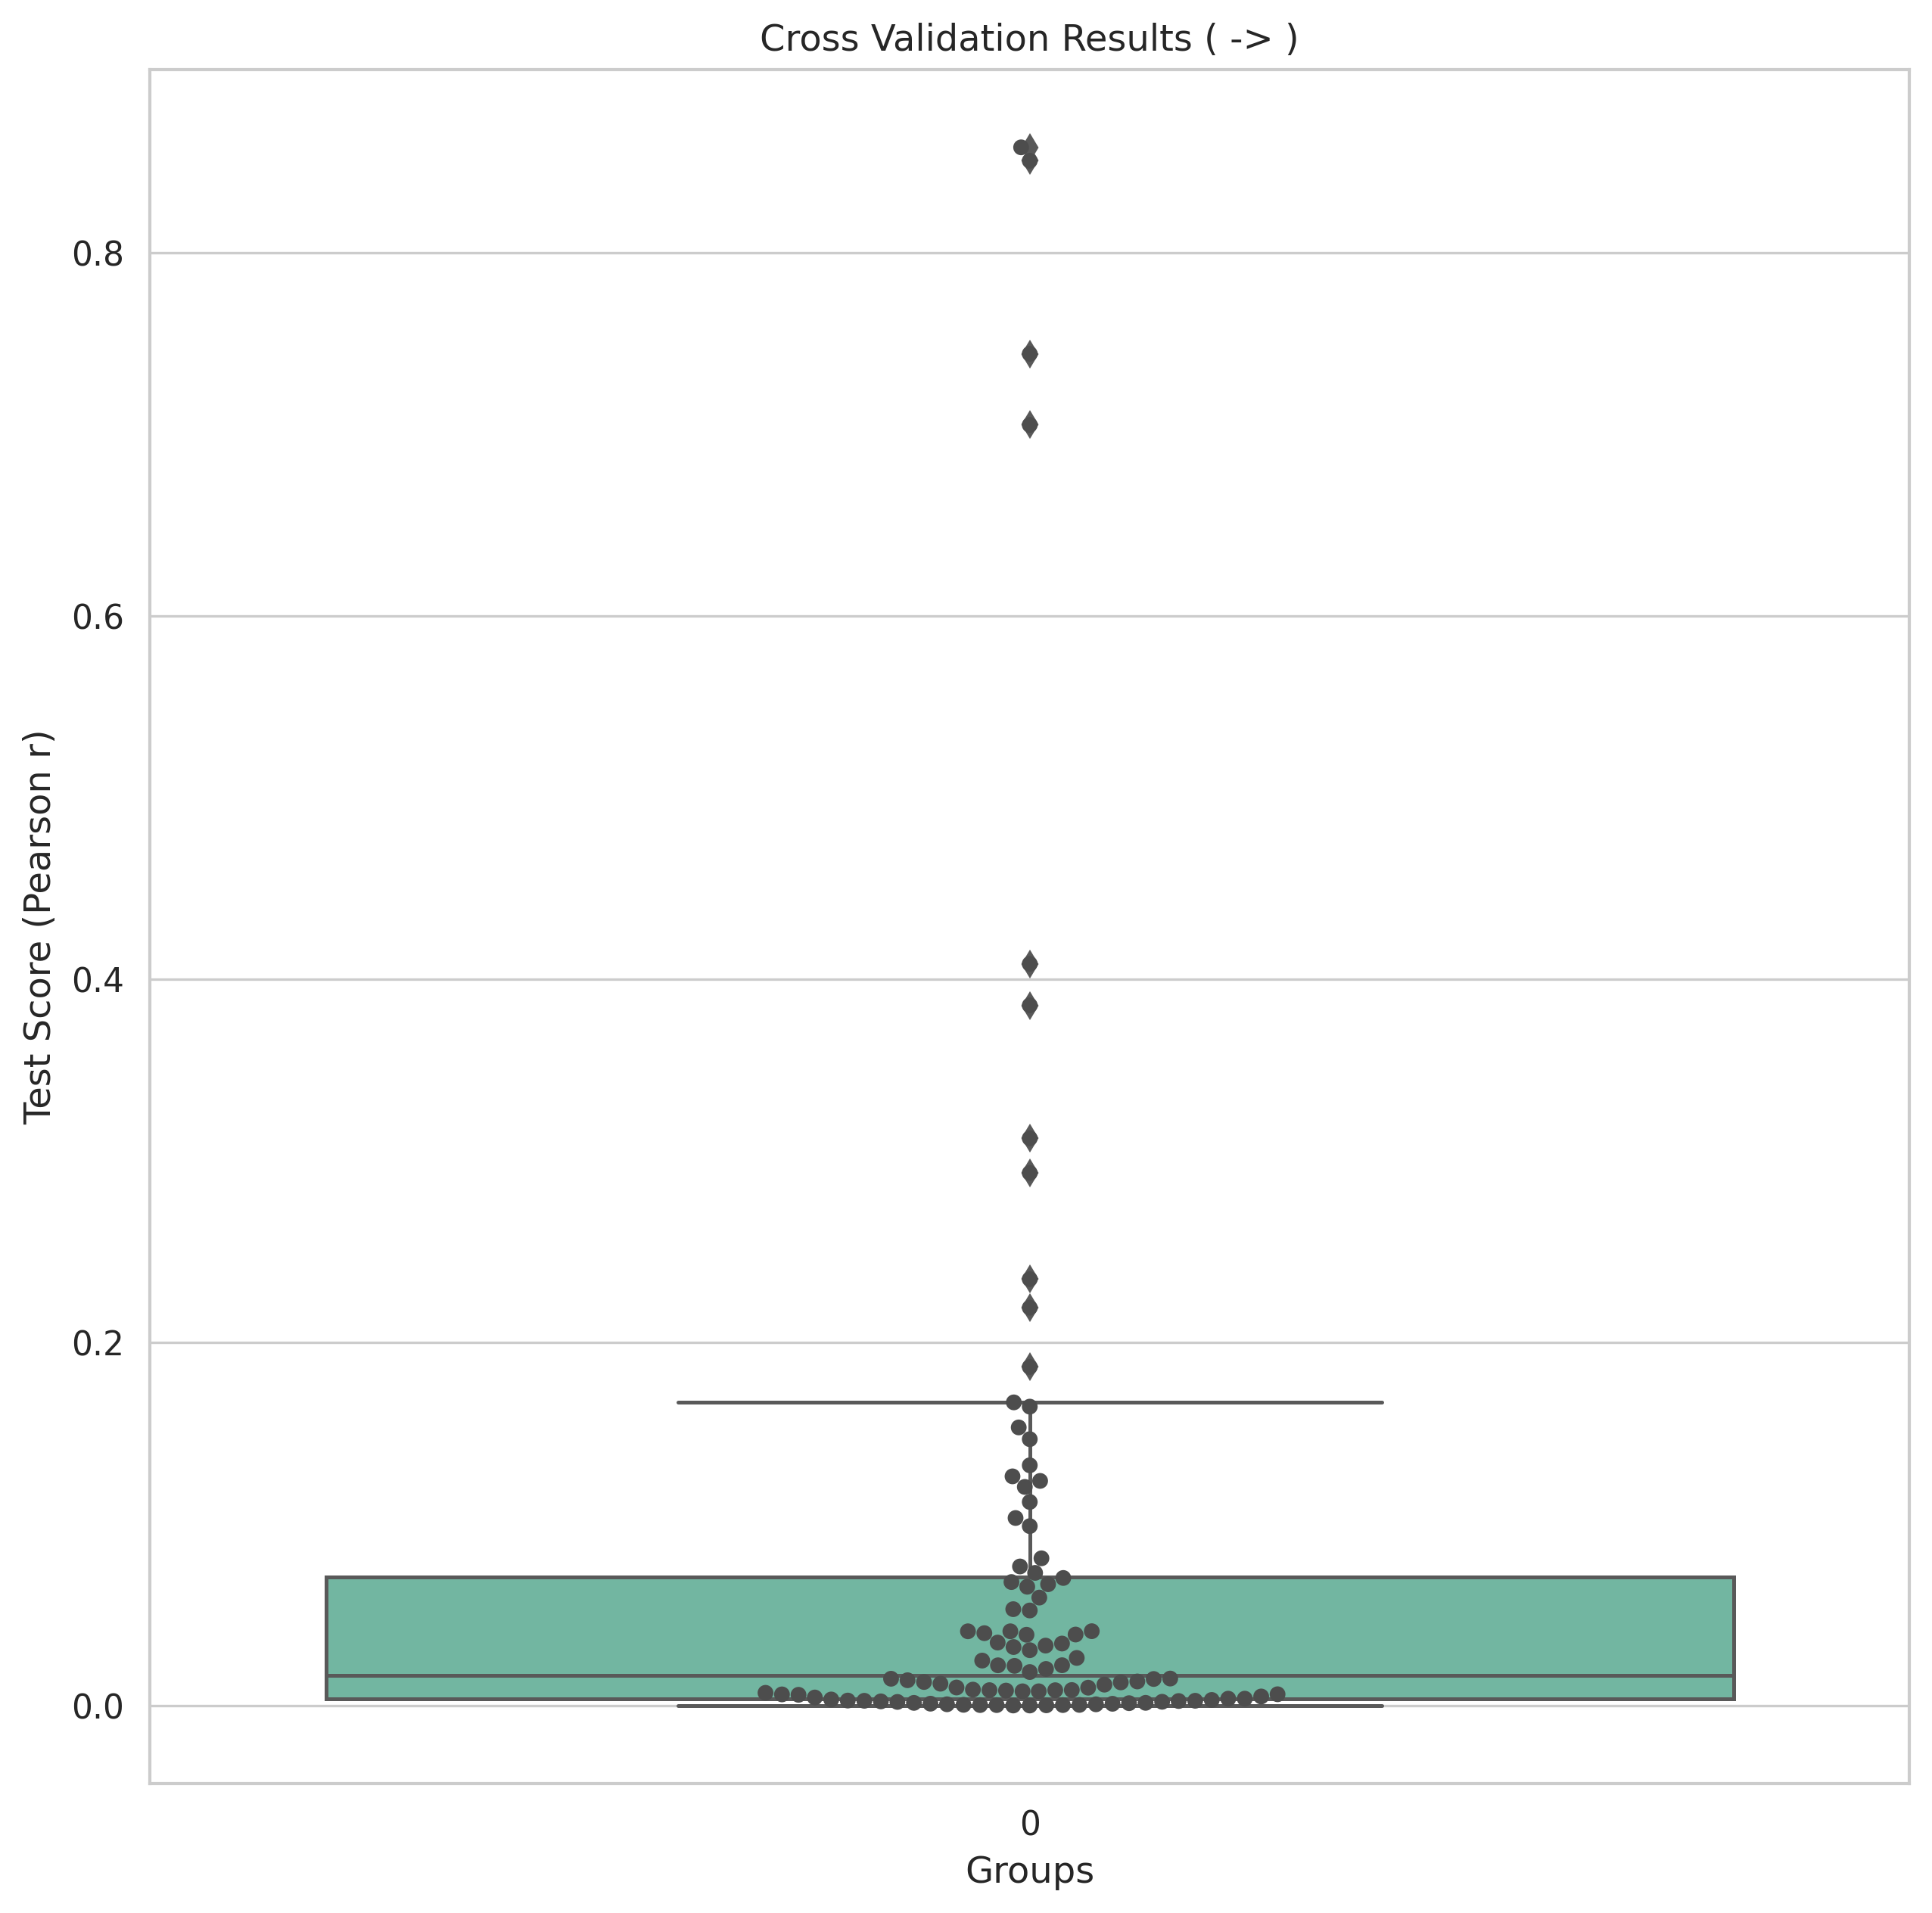

In [20]:
ax = sns.boxplot(data=scores['test_p_value'], palette="Set2")
ax = sns.swarmplot(data=scores['test_p_value'], color="0.3")
ax.set_ylabel('Test Score (Pearson r)')
ax.set_xlabel('Groups')
ax.set_title('Cross Validation Results ( -> )')

In [30]:
from os.path import join
from common.paths import PLS_WEIGHTS

filename = f'pls_{population}_{selected_target}_{age_group}.npy'

np.save(join(PLS_WEIGHTS, filename), avg_coef)

#### ICC

In [31]:
%%time
import pingouin as pg

icc_data = pd.DataFrame(coefs).melt(var_name='connection', value_name='weight', ignore_index=False)
icc_data['cv_run_num'] = icc_data.index
icc = pg.intraclass_corr(data=icc_data, targets='connection', raters='cv_run_num', ratings='weight').round(3)
icc.set_index("Type")

CPU times: user 17min 38s, sys: 7.77 s, total: 17min 46s
Wall time: 17min 45s


,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.892,823.213,34715,3436884,0.0,"[0.89, 0.89]"
ICC2,Single random raters,0.892,823.298,34715,3436785,0.0,"[0.89, 0.89]"
ICC3,Single fixed raters,0.892,823.298,34715,3436785,0.0,"[0.89, 0.89]"
ICC1k,Average raters absolute,0.999,823.213,34715,3436884,0.0,"[1.0, 1.0]"
ICC2k,Average random raters,0.999,823.298,34715,3436785,0.0,"[1.0, 1.0]"
ICC3k,Average fixed raters,0.999,823.298,34715,3436785,0.0,"[1.0, 1.0]"


### Run permutation statistic

In [23]:
%%time
# X_cv = bin_1[0]
# y_cv = bin_1[1]
X_cv = X
y_cv = y
age_group = 'all'

score, _, pvalue = permutation_test_score(
    pipe, X_cv, y_cv, cv=rkf, scoring=unimetric_scorer, n_permutations=N_PERM, n_jobs=-1)

# print(f'Model: PLS | Group: {population} | Target: {selected_target} | Age: {age_group}')
print(f'pls_{population}_{selected_target}_{age_group}')
print(f'Score: {score:.2f} | p-value: {pvalue:.4f}')

pls_healthy_WISC_PSI_all
Score: -0.06 | p-value: 0.6934
CPU times: user 2min 9s, sys: 4.18 s, total: 2min 13s
Wall time: 4h 47min 31s


## Run for all targets, all age bins

In [ ]:
%%time
from common.binning import bin_by_age
from common.wisc import FSIQ, PRIMARY_INDICES
from common.paths import PLS_RESULTS

results = []
targets = FSIQ + PRIMARY_INDICES

for target in targets:
    y = Y[target]
    bins = bin_by_age(X, y, ages, y)
    bin_1, bin_2, bin_3 = bins[0], bins[1], bins[2]
    X_all = [X, bin_1[0], bin_2[0], bin_3[0]]
    y_all = [y, bin_1[1], bin_2[1], bin_3[1]]
    bin_labels = ["All", "Bin 1", "Bin 2", "Bin 3"]
    
    for X_cv, y_cv, bin_label in zip(X_all, y_all, bin_labels):
        score, permutation_scores, pvalue = permutation_test_score(
            pipe, X_cv, y_cv, cv=RKF_10_10, scoring=unimetric_scorer, n_permutations=N_PERM, 
            n_jobs=-1)
        results.append({    
            'Model': 'pls',
            'Population': population,
            'Target': target,
            'Bin': bin_label,
            'Score': score,
            'P-value': pvalue,
        })
        print(results[-1])

results_df = pd.DataFrame(results)
display(results_df)
results_df.to_csv(PLS_RESULTS)